# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import sys
print("Python Version:", sys.version)


Python Version: 3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:43:38) [Clang 15.0.7 ]


In [2]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark import SparkFiles

from pyspark.sql import SparkSession

from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import TimestampType


from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, desc, countDistinct, first
from pyspark.sql.functions import udf, trim,expr
from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek, hour, date_format, substring,datediff
from pyspark.sql.functions import sum as spark_sum, avg as spark_avg

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.sql import Row
from tabulate import tabulate

import pickle



import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Data Exploration") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/29 09:07:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

In [5]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1709219259887'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', 'isabelles-air.lan'),
 ('spark.driver.port', '65494'),
 ('spark.app.startTime', '1709219259057'),
 ('spark.app.submitTime', '1709219258915'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.se

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### GETTING MINI DATASET FROM PUBLIC HTTP LINK
For the 12GB dataset, I uploaded it in an S3 bucket I created because I could not access the data from the S3 URI link provided by the class.

In [6]:
spark.sparkContext.addFile("https://udacity-dsnd.s3.amazonaws.com/sparkify/mini_sparkify_event_data.json")


In [7]:
user_log = spark.read.json("file://" +SparkFiles.get("mini_sparkify_event_data.json"))

In [8]:
# showing the first line of the dataset
user_log.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [9]:
# printing out headers
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



It looks like one row is a record of a song played, so we have the artist name and the song name, as well as the length of the session. 

In [10]:
user_log.filter(col("page") == "Cancel").take(1)

[Row(artist=None, auth='Logged In', firstName='Adriel', gender='M', itemInSession=103, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='PUT', page='Cancel', registration=1535623466000, sessionId=514, song=None, status=307, ts=1538943740000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18')]

When the user is in a page without song playing, length it None, so length correspond to the length of the song played.

## Missing data and invalid data

We will start exploring the data using SQL, so we need to create a temporary view.

In [11]:
user_log.createOrReplaceTempView("user_log_table")
spark.sql('DESC user_log_table\
          ').show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       artist|   string|   NULL|
|         auth|   string|   NULL|
|    firstName|   string|   NULL|
|       gender|   string|   NULL|
|itemInSession|   bigint|   NULL|
|     lastName|   string|   NULL|
|       length|   double|   NULL|
|        level|   string|   NULL|
|     location|   string|   NULL|
|       method|   string|   NULL|
|         page|   string|   NULL|
| registration|   bigint|   NULL|
|    sessionId|   bigint|   NULL|
|         song|   string|   NULL|
|       status|   bigint|   NULL|
|           ts|   bigint|   NULL|
|    userAgent|   string|   NULL|
|       userId|   string|   NULL|
+-------------+---------+-------+



As suggested let's see if userId has any missing data or sessionId

In [12]:
### Missing or invalid data in userids or sessionid
spark.sql('SELECT * \
           FROM user_log_table \
           WHERE userId IS NULL \
            ').show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [13]:
spark.sql('SELECT * \
           FROM user_log_table \
           WHERE sessionId IS NULL \
            ').show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



There is no null values for both userId or sessionId. Maybe missing data is coded differently. Let's look at the userId list.

In [14]:
spark.sql('SELECT DISTINCT userId \
           FROM user_log_table \
           ORDER BY userId \
            ').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [15]:
spark.sql('SELECT DISTINCT sessionId \
           FROM user_log_table \
           ORDER BY sessionId \
            ').show()

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=28393Kb max_used=28393Kb free=102678Kb
 bounds [0x000000010a9e0000, 0x000000010c5d0000, 0x00000001129e0000]
 total_blobs=11379 nmethods=10394 adapters=894
 compilation: disabled (not enough contiguous free space left)
+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



There are userids that have empty strings. Who are these users?
Since we don't know if this is the same user or multiple users, we are going to remove all userid with empty strings. We know that in auth, there is a guest value, let's check if the empty string userid are those who are guest so they did not register to the platform.

In [16]:
spark.sql('SELECT COUNT(userId) AS empty_strings_in_userid \
           FROM user_log_table \
           WHERE userId = "" \
            ').show()

+-----------------------+
|empty_strings_in_userid|
+-----------------------+
|                   8346|
+-----------------------+



In [17]:
spark.sql('SELECT DISTINCT auth\
           FROM user_log_table \
           WHERE userId = "" \
          ').show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



We see that both logged out and guests do not have a userId, so it makes sense to remove them, since we cannot associated them with any user.

In [18]:
#filtering out rows with '' for userId
condition = user_log.userId != ''
user_log_filtered= user_log.filter(condition)

In [19]:
#rebuild database view
user_log_filtered.createOrReplaceTempView("user_log_table_filtered")


In [20]:
spark.sql('SELECT COUNT(*) num_records_after_filtering\
           FROM user_log_table_filtered\
           ').show()

+---------------------------+
|num_records_after_filtering|
+---------------------------+
|                     278154|
+---------------------------+



In [21]:
spark.sql('SELECT COUNT(DISTINCT userId) AS userId_count\
           FROM user_log_table_filtered\
           ').show()

+------------+
|userId_count|
+------------+
|         225|
+------------+



We have 278154 remaining records and 225 users. (which makes sense since userid with empty strings counted as 1).

Let's continue with the user_log_filtered df

In [22]:
spark.sql('SELECT page, COUNT(*) AS number_visits\
            FROM user_log_table_filtered\
            GROUP BY page\
            ORDER BY page').show()

+--------------------+-------------+
|                page|number_visits|
+--------------------+-------------+
|               About|          495|
|          Add Friend|         4277|
|     Add to Playlist|         6526|
|              Cancel|           52|
|Cancellation Conf...|           52|
|           Downgrade|         2055|
|               Error|          252|
|                Help|         1454|
|                Home|        10082|
|              Logout|         3226|
|            NextSong|       228108|
|         Roll Advert|         3933|
|       Save Settings|          310|
|            Settings|         1514|
|    Submit Downgrade|           63|
|      Submit Upgrade|          159|
|         Thumbs Down|         2546|
|           Thumbs Up|        12551|
|             Upgrade|          499|
+--------------------+-------------+



In [23]:
#checking unique values in auth
spark.sql('SELECT DISTINCT auth, COUNT (DISTINCT userId) AS count\
            FROM user_log_table_filtered \
            GROUP BY auth\
            ').show()
#auth show the status of the user when they are using the platform
#NB: check the number of unique users using the platform as cancelled and see if it matched with churn users

+---------+-----+
|     auth|count|
+---------+-----+
|Cancelled|   52|
|Logged In|  225|
+---------+-----+



This look right, there are a total of 225 unique users who at some point had auth= logged in and the 52 users among these who cancelled.
Since this will represent churn too, I will drop auth.

In [24]:
#checking unique values in status
spark.sql('SELECT DISTINCT status\
            FROM user_log_table_filtered\
            ').show()


+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [25]:
#checking unique values in method
spark.sql('SELECT DISTINCT method\
            FROM user_log_table_filtered\
            ').show()


+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [26]:
spark.sql('SELECT DISTINCT page\
          FROM user_log_table_filtered').show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [27]:
#How many records does the dataset have?
spark.sql('SELECT COUNT(*) AS number_rows\
            FROM user_log_table_filtered').show()

+-----------+
|number_rows|
+-----------+
|     278154|
+-----------+



In [28]:
#How many distint users?
spark.sql('SELECT COUNT(DISTINCT userid) AS unique_users\
            FROM user_log_table_filtered\
            ').show()

+------------+
|unique_users|
+------------+
|         225|
+------------+



In this dataset there are 225 unique users

In [29]:
# how many paid and free users?
spark.sql('SELECT COUNT(DISTINCT userid) AS paid_free\
            FROM user_log_table_filtered\
            GROUP BY level').show()

+---------+
|paid_free|
+---------+
|      195|
|      165|
+---------+



This doesn't sum up so it means that at some point, some users went from paid to free, or vice versa

The churn column will be create using Cancellation Confirmation, which is the same number as Cancel. We can quickly check if the userId who went on cancel are the same as those who went to Cancellation confirmation

#### Feature documentation and decision 

The data includes the following columns:
- artist (string) : artist/singer name - keep
- auth (string): user status - **drop as redundant with churn**
- firstName (string) : user first name - **drop as redundant with userid**
- gender (string): user's gender (female or male) - keep - can be changed to categorical
- itemInSession (long): number of events during the current session - keep
- lastName (string) : user's lastname - **drop as redundant with userid**
- length (double): duration of song played - keep 
- level (string): subscription level (paid or free) - keep - can be changed to categorical.
- location (string): user's location format city, state (in the USA) - keep- can be engineered by separating state
- method (string): (put or get) - **drop**
- page (string): page where the user is - keep
- registration (long): timestamp of when the user registered. - keep - change time format, and check if there is any data for guests.
- sessionId (long): unique Id for the session the user is in ***drop***
- song (string): song playing - keep
- status (long): looks like page error status
- ts (long): timestamp , must be time when the user started the session 
- userAgent ( string ) : browser keep and change to categorical
- userId ( string) unique Id per user - keep 

#### Features to drop
- firstname, lastname, method, auth

In [30]:
cols = ("firstname","lastname","method","auth")
user_log = user_log_filtered.drop(*cols)
user_log.printSchema()  

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [31]:
user_log.createOrReplaceTempView("user_log_table")
spark.sql('DESC user_log_table\
          ').show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       artist|   string|   NULL|
|       gender|   string|   NULL|
|itemInSession|   bigint|   NULL|
|       length|   double|   NULL|
|        level|   string|   NULL|
|     location|   string|   NULL|
|         page|   string|   NULL|
| registration|   bigint|   NULL|
|    sessionId|   bigint|   NULL|
|         song|   string|   NULL|
|       status|   bigint|   NULL|
|           ts|   bigint|   NULL|
|    userAgent|   string|   NULL|
|       userId|   string|   NULL|
+-------------+---------+-------+



# Feature engineering
This will include:
- taking care of any time related features: ts and registration
- creating new features using time related features: registration month etc..
- identifying missing data and make a decision on these
- finalizing features selected and check their type (categorical binary etc.)

## Reformating time features into date

In [32]:
# these two columns have timestamps so they will be engineered to extract data on time (day, month, year)
spark.sql('SELECT ts, registration \
          FROM user_log_table\
          LIMIT 10 ').show()

+-------------+-------------+
|           ts| registration|
+-------------+-------------+
|1538352117000|1538173362000|
|1538352180000|1538331630000|
|1538352394000|1538173362000|
|1538352416000|1538331630000|
|1538352676000|1538173362000|
|1538352678000|1538331630000|
|1538352886000|1538331630000|
|1538352899000|1538173362000|
|1538352905000|1538173362000|
|1538353084000|1538173362000|
+-------------+-------------+



ts and registration are timestamps so we will convert into readable time

In [33]:
user_log = user_log.withColumn('ts_ts', (col('ts') / 1000.0).cast(TimestampType()))

In [34]:
user_log = user_log.withColumn('ts_todate', to_date('ts_ts'))

In [35]:
user_log = user_log.withColumn('registration_ts', (col('registration') / 1000.0).cast(TimestampType()))

In [36]:
user_log = user_log.withColumn('registration_todate', to_date('registration_ts'))

In [37]:
cols = ("ts","registration","ts_ts","registration_ts")
user_log = user_log.drop(*cols)

In [38]:
#recreate sql view
user_log.createOrReplaceTempView("user_log_table")
spark.sql('DESC user_log_table').show()

+-------------------+---------+-------+
|           col_name|data_type|comment|
+-------------------+---------+-------+
|             artist|   string|   NULL|
|             gender|   string|   NULL|
|      itemInSession|   bigint|   NULL|
|             length|   double|   NULL|
|              level|   string|   NULL|
|           location|   string|   NULL|
|               page|   string|   NULL|
|          sessionId|   bigint|   NULL|
|               song|   string|   NULL|
|             status|   bigint|   NULL|
|          userAgent|   string|   NULL|
|             userId|   string|   NULL|
|          ts_todate|     date|   NULL|
|registration_todate|     date|   NULL|
+-------------------+---------+-------+



#### ts and registration were reformated and are now dates. Let's take a look

In [39]:
spark.sql('SELECT ts_todate, registration_todate\
           FROM user_log_table').show()

+----------+-------------------+
| ts_todate|registration_todate|
+----------+-------------------+
|2018-09-30|         2018-09-28|
|2018-09-30|         2018-09-30|
|2018-09-30|         2018-09-28|
|2018-09-30|         2018-09-30|
|2018-09-30|         2018-09-28|
|2018-09-30|         2018-09-30|
|2018-09-30|         2018-09-30|
|2018-09-30|         2018-09-28|
|2018-09-30|         2018-09-28|
|2018-09-30|         2018-09-28|
|2018-09-30|         2018-09-30|
|2018-09-30|         2018-09-30|
|2018-09-30|         2018-09-28|
|2018-09-30|         2018-09-30|
|2018-09-30|         2018-09-30|
|2018-09-30|         2018-09-28|
|2018-09-30|         2018-09-30|
|2018-09-30|         2018-09-19|
|2018-09-30|         2018-09-28|
|2018-09-30|         2018-09-30|
+----------+-------------------+
only showing top 20 rows



In [40]:
# what time interval are the records of this subset?
spark.sql('SELECT MIN(ts_todate), MAX(ts_todate)\
           FROM user_log_table\
          ').show()

+--------------+--------------+
|min(ts_todate)|max(ts_todate)|
+--------------+--------------+
|    2018-09-30|    2018-12-02|
+--------------+--------------+



The data examined here are records ranging from Setp 30 2018 to Dec 12 2018.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [41]:
spark.sql('SELECT COUNT(DISTINCT userid)\
           FROM user_log_table\
           WHERE page = "Cancellation Confirmation"\
          ').show()

+----------------------+
|count(DISTINCT userid)|
+----------------------+
|                    52|
+----------------------+



In [42]:
52/225*100

23.11111111111111

In the small dataset has 52 churning users which makes 23% rate on this data set. Let's check over what timeframe the dataset includes sessions.

Let's use Cancellation Confirmation to create the churn label.

In [43]:
#function to create the churn label
create_churn = udf(lambda x: 1 if x =="Cancellation Confirmation" else 0, IntegerType())

user_log_clean = user_log.withColumn('churn_lab', create_churn('page'))

In [44]:
user_log_clean.take(1)

/Users/isabellevea/anaconda3/envs/streamlit/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py:154: DeprecationWarning: This process (pid=41815) is multi-threaded, use of fork() may lead to deadlocks in the child.


[Row(artist='Martha Tilston', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0)]

Since we only defined churn binary coding based on 'page', and that the whole dataset is based on sessionid, we are going to have users that churned but with a 0 label for all the pages they have been to that are not cancellation confirmation.

Now let's replace all the 0 of churn users to 1.



In [45]:
# collect all the users with 1 for churn_lab
churn_userid = user_log_clean.select('userId').where(col('churn_lab')==1).groupby('userId').count()
churn_userid_list = [row['userId'] for row in churn_userid.collect()]
len(churn_userid_list)

52

In [46]:
user_log_clean = user_log_clean.withColumn('churn_lab2', when((user_log_clean.userId).isin(churn_userid_list), 1).otherwise(0))

In [47]:
user_log_clean.take(1)

[Row(artist='Martha Tilston', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0, churn_lab2=0)]

In [48]:
user_log_clean.createOrReplaceTempView("user_log_table_clean")


In [49]:
spark.sql('SELECT userId, churn_lab, churn_lab2\
           FROM user_log_table_clean \
           WHERE churn_lab2 = 1').show()

+------+---------+----------+
|userId|churn_lab|churn_lab2|
+------+---------+----------+
|    54|        0|         1|
|    54|        0|         1|
|    54|        0|         1|
|    54|        0|         1|
|    54|        0|         1|
|    54|        0|         1|
|    54|        0|         1|
|    54|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
+------+---------+----------+
only showing top 20 rows



In [50]:
user_log_clean = user_log_clean.drop("churn_lab")
user_log_clean.take(1)

[Row(artist='Martha Tilston', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab2=0)]

### Function for churn labeling

In [51]:
# function for churn labeling
def create_churn_label(df):
    ''' This function takes a dataframe and creates churn labels based on the 
    churn definition: Cancellation Confirmation value in 'pages' is considered churn.
    
    Input = Spark dataframe
    
    Output = Spark dataframe with new column 'churn_lab' for each user who churned
    '''
    #labeling all 'pages' with Cancellation Confirmation
    create_churn = udf(lambda x: 1 if x =="Cancellation Confirmation" else 0, IntegerType())
    df = df.withColumn('churn_lab_temp', create_churn('page'))
    
    #extract a list of churn users from the new df
    churn_userid = df.select('userId').where(col('churn_lab_temp')==1).groupby('userId').count()
    churn_userid_list = [row['userId'] for row in churn_userid.collect()]
    
    #new column based on the churn list
    df = df.withColumn('churn_lab', when((user_log_clean.userId).isin(churn_userid_list), 1).otherwise(0))
    
    #dropping column
    df = df.drop('churn_lab_temp')
    
    return df   

In [52]:
#let's test the function on a copy of the dataframe
user_log_test = user_log

In [53]:
user_log_test_churn = create_churn_label(user_log_test)

In [54]:
user_log_test_churn.take(1)

[Row(artist='Martha Tilston', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0)]

In [55]:
user_log_test_churn.select('churn_lab').groupby('churn_lab').count().show()

+---------+------+
|churn_lab| count|
+---------+------+
|        1| 44864|
|        0|233290|
+---------+------+



The function works and will be added into the python script.




### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [56]:
#using the dataset created from the churn function
user_log_clean_churn = user_log_test_churn

In [57]:
#clean data sql view
user_log_clean_churn.createOrReplaceTempView("user_log_clean_churn_table")

In [58]:
spark.sql('DESC user_log_clean_churn_table').show()

+-------------------+---------+-------+
|           col_name|data_type|comment|
+-------------------+---------+-------+
|             artist|   string|   NULL|
|             gender|   string|   NULL|
|      itemInSession|   bigint|   NULL|
|             length|   double|   NULL|
|              level|   string|   NULL|
|           location|   string|   NULL|
|               page|   string|   NULL|
|          sessionId|   bigint|   NULL|
|               song|   string|   NULL|
|             status|   bigint|   NULL|
|          userAgent|   string|   NULL|
|             userId|   string|   NULL|
|          ts_todate|     date|   NULL|
|registration_todate|     date|   NULL|
|          churn_lab|      int|   NULL|
+-------------------+---------+-------+



- Session count : Do users who did not churn use Sparkify more often than users who churned?

In [59]:
# how many sessions did each userId create?
session_count_by_churn = user_log_clean_churn.groupby('userId','churn_lab').agg(count("*").alias("count")).toPandas()

<Axes: xlabel='userId', ylabel='count'>

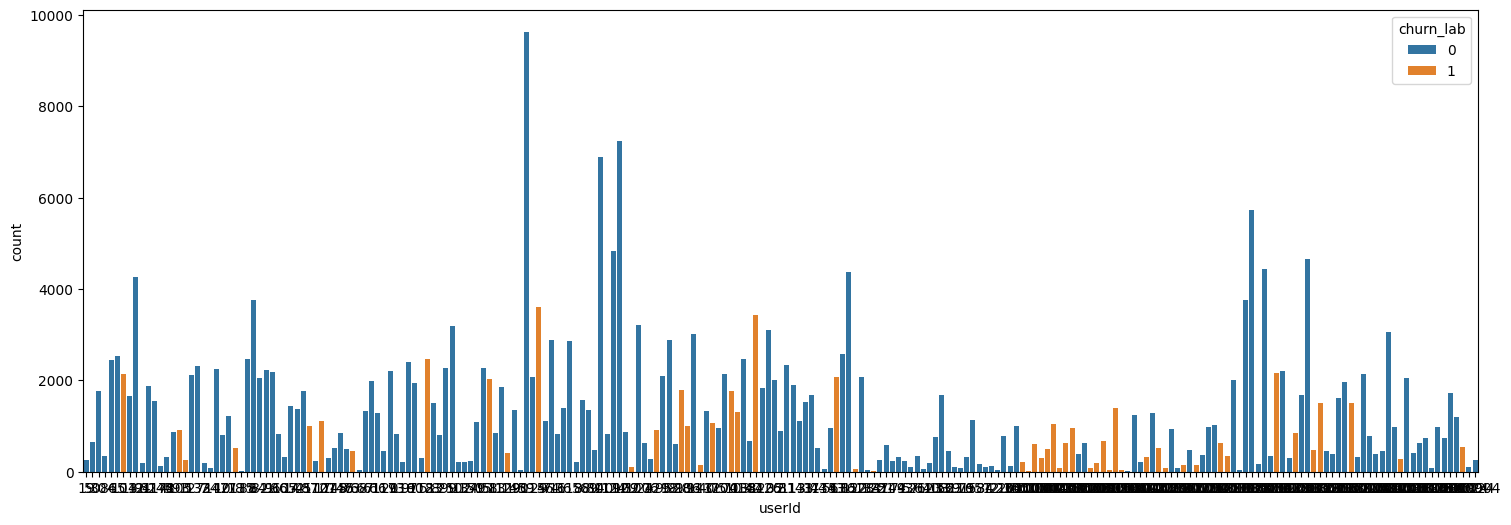

In [60]:
#plot of session count for each user.
plt.figure(figsize=(18, 6))
sns.barplot(data=session_count_by_churn, x='userId', y='count', hue='churn_lab')


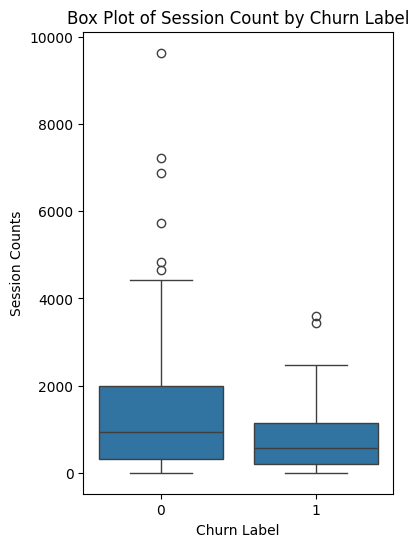

In [61]:
plt.figure(figsize=(4, 6))
sns.boxplot(x="churn_lab", y="count", data=session_count_by_churn)

# Labels and Title
plt.xlabel('Churn Label')
plt.ylabel('Session Counts')
plt.title('Box Plot of Session Count by Churn Label')

# Show the plot
plt.show()


Answer: yes.
Decision: we will create a feature counting the number of sessions for each user.

- artist

In [62]:
artist_by_churn = user_log_clean_churn.groupby('artist','churn_lab').agg(count("*").alias("count")).toPandas().sort_values(by=['count'], ascending = False)

In [63]:
artist_by_churn.head()

,artist,churn_lab,count
17028,None,0,41576
2244,None,1,8470
14785,Coldplay,0,1552
16079,Kings Of Leon,0,1542
12669,Florence + The Machine,0,1048


We see that the most played artist is coldplay with no churn, and over 40000 sessions did not play any songs. These sessions are the pages where there is no active song being played.

#### count of unique artists listen to by churn group


In [64]:
count_artist_by_user_churn = user_log_clean_churn.groupby('churn_lab','userId').agg(countDistinct("artist").alias("count")).toPandas().sort_values(by=['count'], ascending = False)

In [65]:
count_artist_by_user_churn.head()

,churn_lab,userId,count
1,0,39,3544
180,0,92,2904
81,0,140,2819
156,0,300011,2491
147,0,124,2232


/var/folders/dd/nb8m5vwd1sz3_s49jh1plcfr0000gn/T/ipykernel_41655/2327218004.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')


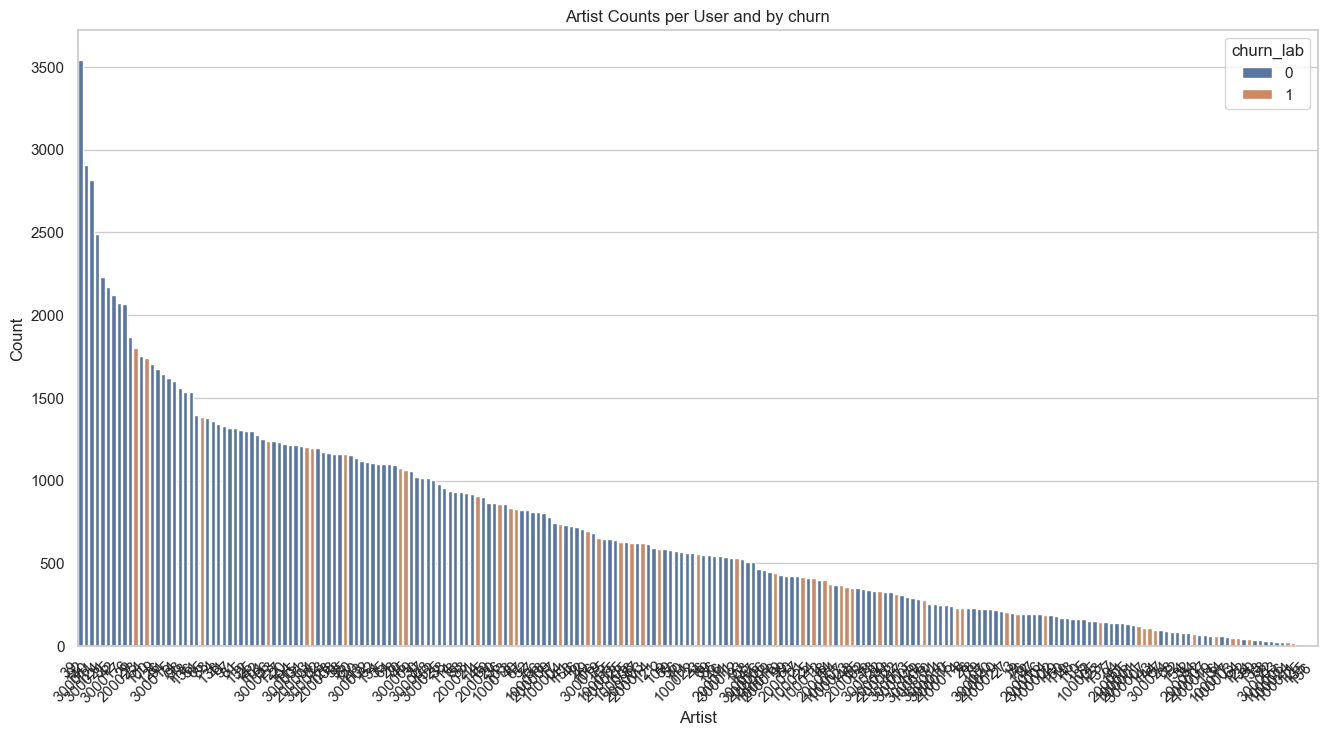

In [66]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))
plot = sns.barplot(x="userId", y="count", hue="churn_lab", data=count_artist_by_user_churn)

# Rotate x-axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title("Artist Counts per User and by churn")
plt.xlabel("Artist")
plt.ylabel("Count")
plt.show()

/var/folders/dd/nb8m5vwd1sz3_s49jh1plcfr0000gn/T/ipykernel_41655/2185680415.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')


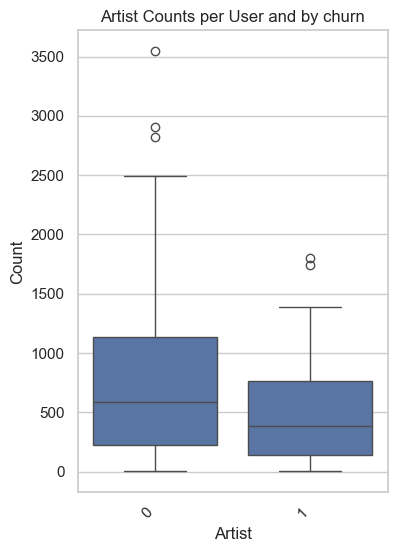

In [67]:
sns.set(style="whitegrid")
plt.figure(figsize=(4, 6))
plot = sns.boxplot(y="count", x="churn_lab", data=count_artist_by_user_churn)

# Rotate x-axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title("Artist Counts per User and by churn")
plt.xlabel("Artist")
plt.ylabel("Count")
plt.show()

- Gender

In [68]:
# take all users, churn and gender, drop duplicate rows by users, 
gender_by_churn = user_log_clean_churn.dropDuplicates(['userId']).groupBy('gender','churn_lab').agg(count('*').alias('user_count')).toPandas()
gender_by_churn.head()

,gender,churn_lab,user_count
0,M,1,32
1,F,0,84
2,F,1,20
3,M,0,89


<Axes: xlabel='gender', ylabel='user_count'>

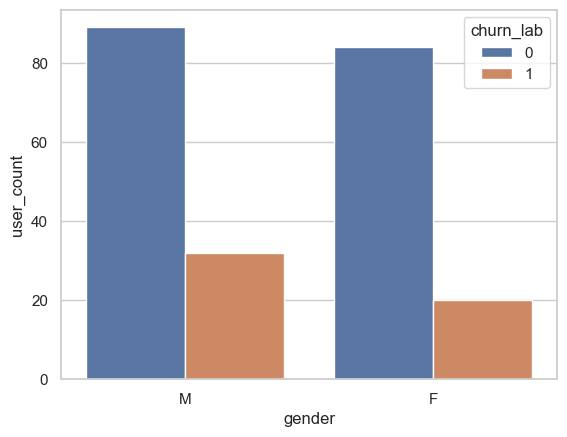

In [69]:
sns.barplot(data=gender_by_churn, x='gender', y='user_count', hue='churn_lab')

There were more male churners than female.
Decision: keep gender information for the model.

- length

In [70]:
user_log_clean_churn.take(1)

[Row(artist='Martha Tilston', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0)]

In [71]:
# look at the average session length per user and churning
columns = ['userId','length','churn_lab']
user_log_clean_length_df = user_log_clean_churn.select(columns)

In [72]:
length_agg_df = user_log_clean_length_df.groupBy("userId", "churn_lab").agg(
                spark_sum("length").alias("total_session_length"),
                spark_avg("length").alias("avg_session_length"))


In [73]:
length_agg_df.take(10)

[Row(userId='19', churn_lab=0, total_session_length=54480.933869999986, avg_session_length=252.22654569444438),
 Row(userId='50', churn_lab=0, total_session_length=122751.27560999998, avg_session_length=244.03832129224648),
 Row(userId='30', churn_lab=0, total_session_length=359808.2456400002, avg_session_length=253.92254455892746),
 Row(userId='8', churn_lab=0, total_session_length=63393.53190999998, avg_session_length=252.56387215139435),
 Row(userId='4', churn_lab=0, total_session_length=506140.04138000007, avg_session_length=247.13869208007816),
 Row(userId='65', churn_lab=0, total_session_length=529357.90542, avg_session_length=250.52432816848082),
 Row(userId='101', churn_lab=1, total_session_length=447464.0146699994, avg_session_length=249.00612947690564),
 Row(userId='13', churn_lab=0, total_session_length=313639.02128999995, avg_session_length=245.03048538281246),
 Row(userId='42', churn_lab=0, total_session_length=881792.96613, avg_session_length=246.79344140218302),
 Row(use

In [74]:
length_agg_pd = length_agg_df.toPandas()


In [75]:
length_agg_pd.sort_values("total_session_length").head(10)

,userId,churn_lab,total_session_length,avg_session_length
168,156,0,691.66884,230.556280
25,135,0,1596.44461,266.074102
127,125,1,2089.11310,261.139138
152,100011,1,2841.69950,258.336318
165,100024,1,5160.53207,234.569640
167,100006,1,5854.89105,225.188117
186,300003,0,6567.87674,243.254694
44,68,0,7079.69297,244.127344
147,22,0,7403.82080,264.422171
126,133,0,8029.16428,250.911384


In [76]:
#check if I have teh same userid with 2 churnlab2
length_agg_pd.duplicated("userId").sum()

0

In [77]:
length_agg_pd["userId"]=length_agg_pd["userId"].astype('category')

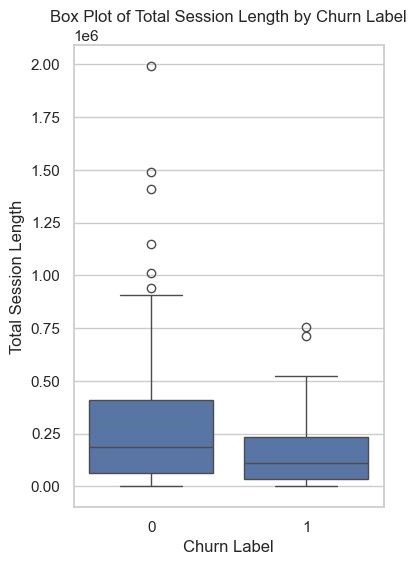

In [78]:
sns.set(style="whitegrid")

plt.figure(figsize=(4, 6))
sns.boxplot(x="churn_lab", y="total_session_length", data=length_agg_pd)

plt.xlabel('Churn Label')
plt.ylabel('Total Session Length')
plt.title('Box Plot of Total Session Length by Churn Label')

plt.show()

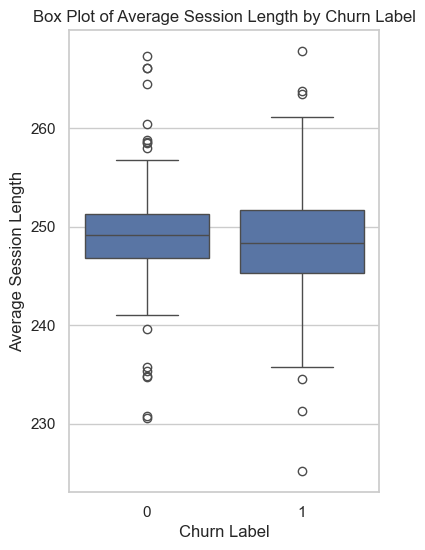

In [79]:
plt.figure(figsize=(4, 6))
sns.boxplot(x="churn_lab", y="avg_session_length", data=length_agg_pd)

plt.xlabel('Churn Label')
plt.ylabel('Average Session Length')
plt.title('Box Plot of Average Session Length by Churn Label')

plt.show()

Even if the both churned customers and not churned have the same average session length, not churn customers have a short total session length.
The average session is probably indicative of the an average song length. In churned users, there seems to be more variability than unchurned maybe because other pages than song playing are explored. Let's keep average session length as an engineered feature.

In [80]:
length_agg_pd[length_agg_pd['total_session_length'].isnull()]

,userId,churn_lab,total_session_length,avg_session_length


- level

In [81]:
user_log_clean_churn.dropDuplicates(['userId']).select(['level','churn_lab']).groupby(['level','churn_lab']).count().show()

+-----+---------+-----+
|level|churn_lab|count|
+-----+---------+-----+
| paid|        0|   40|
| free|        0|  133|
| paid|        1|    8|
| free|        1|   44|
+-----+---------+-----+



this columns is related to the cancellation that I used for churn labeling so I am dropping it.

- location

In [82]:
user_log_clean_churn.dropDuplicates(['userId']).select('location').groupby('location').count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL|    1|
|Atlantic City-Ham...|    1|
|Cleveland-Elyria, OH|    1|
|San Diego-Carlsba...|    3|
|Deltona-Daytona B...|    1|
|Kingsport-Bristol...|    1|
|New Haven-Milford...|    3|
|Birmingham-Hoover...|    1|
|  Corpus Christi, TX|    1|
|         Dubuque, IA|    1|
|Las Vegas-Henders...|    3|
|Indianapolis-Carm...|    2|
|Seattle-Tacoma-Be...|    2|
|          Albany, OR|    1|
|   Winston-Salem, NC|    1|
|Los Angeles-Long ...|   16|
|     Bakersfield, CA|    1|
|Minneapolis-St. P...|    2|
|San Francisco-Oak...|    2|
|Phoenix-Mesa-Scot...|    7|
+--------------------+-----+
only showing top 20 rows



In [83]:
split_col = pyspark.sql.functions.split(user_log_clean_churn['location'], ', ')
user_log_clean_churn = user_log_clean_churn.withColumn('city', split_col.getItem(0))
user_log_clean_churn = user_log_clean_churn.withColumn('state', split_col.getItem(1))


In [84]:
user_log_clean_churn.take(5)

[Row(artist='Martha Tilston', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0, city='Bakersfield', state='CA'),
 Row(artist='Five Iron Frenzy', gender='M', itemInSession=79, length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', page='NextSong', sessionId=8, song='Canada', status=200, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 30), churn_lab=0, city='Boston-Cambridge-Newton', state='MA-NH'),
 Row(artist='Adam Lambert', gender='M', itemInSession=51, length=282.8273, level='paid', location='Bakersfield

In [85]:
user_log_clean_churn_df = user_log_clean_churn.toPandas()
user_log_clean_churn_df.head()

,artist,gender,itemInSession,length,level,location,page,sessionId,song,status,userAgent,userId,ts_todate,registration_todate,churn_lab,city,state
0,Martha Tilston,M,50,277.89016,paid,"Bakersfield, CA",NextSong,29,Rockpools,200,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-09-30,2018-09-28,0,Bakersfield,CA
1,Five Iron Frenzy,M,79,236.09424,free,"Boston-Cambridge-Newton, MA-NH",NextSong,8,Canada,200,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-09-30,2018-09-30,0,Boston-Cambridge-Newton,MA-NH
2,Adam Lambert,M,51,282.82730,paid,"Bakersfield, CA",NextSong,29,Time For Miracles,200,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-09-30,2018-09-28,0,Bakersfield,CA
3,Enigma,M,80,262.71302,free,"Boston-Cambridge-Newton, MA-NH",NextSong,8,Knocking On Forbidden Doors,200,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-09-30,2018-09-30,0,Boston-Cambridge-Newton,MA-NH
4,Daft Punk,M,52,223.60771,paid,"Bakersfield, CA",NextSong,29,Harder Better Faster Stronger,200,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-09-30,2018-09-28,0,Bakersfield,CA


In [86]:
user_log_clean_churn_df['location'].unique()

array(['Bakersfield, CA', 'Boston-Cambridge-Newton, MA-NH',
       'Tallahassee, FL', 'Spokane-Spokane Valley, WA',
       'Baltimore-Columbia-Towson, MD', 'Denver-Aurora-Lakewood, CO',
       'McAllen-Edinburg-Mission, TX', 'Columbus, GA-AL',
       'Phoenix-Mesa-Scottsdale, AZ',
       'Tampa-St. Petersburg-Clearwater, FL',
       'New York-Newark-Jersey City, NY-NJ-PA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD',
       'Atlanta-Sandy Springs-Roswell, GA',
       'Los Angeles-Long Beach-Anaheim, CA', 'Quincy, IL-MO',
       'New Philadelphia-Dover, OH', 'Kingsport-Bristol-Bristol, TN-VA',
       'Myrtle Beach-Conway-North Myrtle Beach, SC-NC', 'Boulder, CO',
       'Morgantown, WV', 'Minneapolis-St. Paul-Bloomington, MN-WI',
       'Oklahoma City, OK', 'Hartford-West Hartford-East Hartford, CT',
       'Lexington-Fayette, KY',
       'Virginia Beach-Norfolk-Newport News, VA-NC',
       'Louisville/Jefferson County, KY-IN',
       'Houston-The Woodlands-Sugar Land, TX', 'Vi

In [87]:
split_col = pyspark.sql.functions.split(user_log_clean_churn['state'], '-')
user_log_clean_churn = user_log_clean_churn.withColumn('state1', split_col.getItem(0))



In [88]:
user_log_clean_churn.take(5)

[Row(artist='Martha Tilston', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0, city='Bakersfield', state='CA', state1='CA'),
 Row(artist='Five Iron Frenzy', gender='M', itemInSession=79, length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', page='NextSong', sessionId=8, song='Canada', status=200, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 30), churn_lab=0, city='Boston-Cambridge-Newton', state='MA-NH', state1='MA'),
 Row(artist='Adam Lambert', gender='M', itemInSession=51, length=282.8273, level='pa

In [89]:
#group by state ''
user_churn_state = user_log_clean_churn.dropDuplicates(['userId']).select('state1','churn_lab').groupby('state1','churn_lab').count()


In [90]:
user_churn_state_df = user_churn_state.toPandas()

<Axes: xlabel='state1', ylabel='count'>

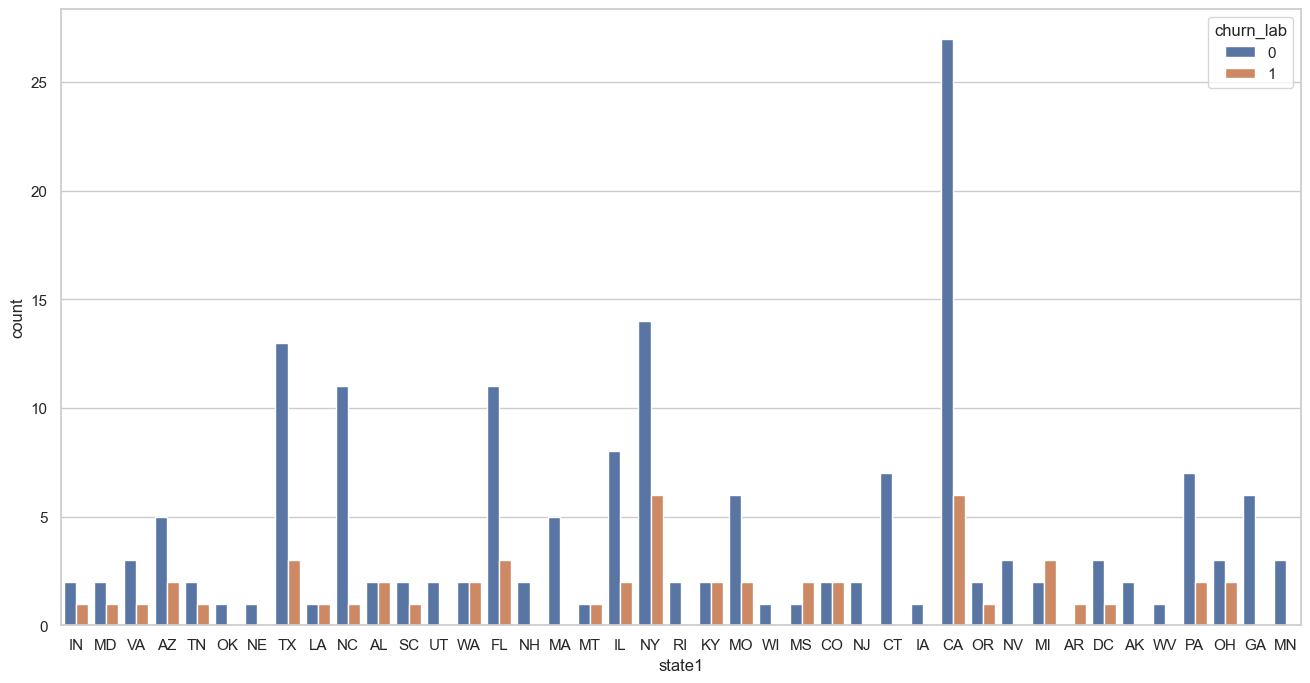

In [91]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

sns.barplot(data=user_churn_state_df, x='state1', y='count', hue='churn_lab')


- page

In [92]:
unique_pages_userid = (
    user_log_clean_churn.groupBy("userId")
    .agg(
        countDistinct("page").alias("UniquePages"),
        first("churn_lab").alias("churn_lab")  # Assuming it's a binary label (0 or 1)
    )
)

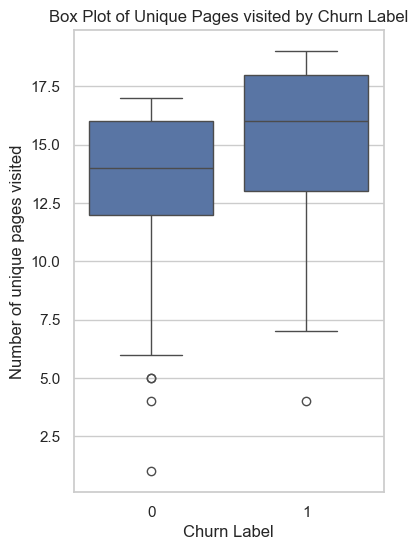

In [93]:
sns.set(style="whitegrid")

plt.figure(figsize=(4, 6))
sns.boxplot(x="churn_lab", y="UniquePages", data=unique_pages_userid.toPandas())

plt.xlabel('Churn Label')
plt.ylabel('Number of unique pages visited')
plt.title('Box Plot of Unique Pages visited by Churn Label')

plt.show()

Decision: create a feature of number of unique pages visited by each user.

In [94]:
count_pages_userid = (
    user_log_clean_churn.groupBy("userId","page")
    .agg(
        count("page").alias("UniquePages"),
        first("churn_lab").alias("churn_lab")  # Assuming it's a binary label (0 or 1)
    )
)

In [95]:
page_counts_per_user = user_log_clean_churn.select("userId", "page","churn_lab").groupBy("userId", "page","churn_lab").count()


In [96]:
page_counts_per_user.show()

+------+---------------+---------+-----+
|userId|           page|churn_lab|count|
+------+---------------+---------+-----+
|    81|       NextSong|        0| 1974|
|     9|          About|        0|    9|
|    20|Add to Playlist|        0|   54|
|   105|      Downgrade|        1|   10|
|    91|     Add Friend|        0|   42|
|    97|    Roll Advert|        0|   24|
|   126|    Thumbs Down|        0|   21|
|    98|Add to Playlist|        0|   58|
|    61|       Settings|        0|    9|
|   105|         Logout|        1|   12|
|    86|         Logout|        0|   12|
|    97|       NextSong|        0| 1975|
|    81|    Thumbs Down|        0|   14|
|   131|       NextSong|        0| 1564|
|   101|Add to Playlist|        1|   61|
|    74|     Add Friend|        0|   43|
|     2|           Home|        0|   35|
|    70|  Save Settings|        1|    4|
|    53|      Thumbs Up|        1|   69|
|     4|         Logout|        0|   24|
+------+---------------+---------+-----+
only showing top

/var/folders/dd/nb8m5vwd1sz3_s49jh1plcfr0000gn/T/ipykernel_41655/3805765037.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')


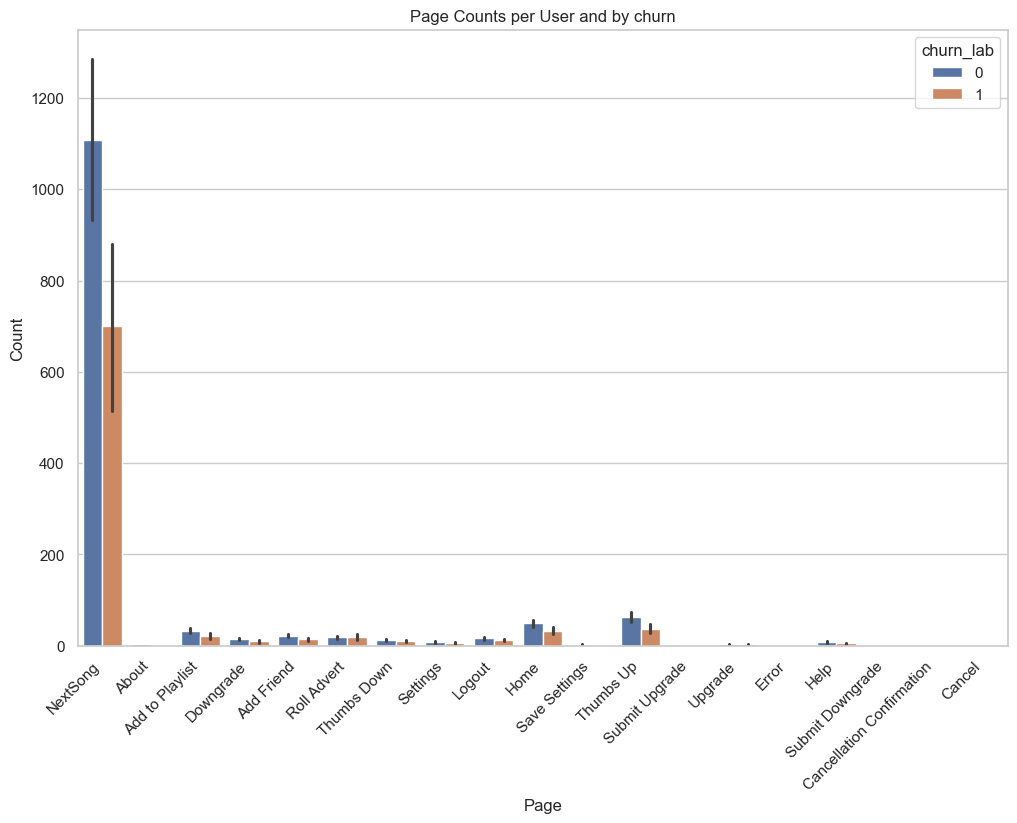

In [97]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
plot = sns.barplot(x="page", y="count", hue="churn_lab", data=page_counts_per_user.toPandas())

# Rotate x-axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title("Page Counts per User and by churn")
plt.xlabel("Page")
plt.ylabel("Count")
plt.show()

In [98]:
pivoted_page_counts_per_user = page_counts_per_user.groupBy("userId","churn_lab").pivot("page").sum("count")


In [99]:
pivoted_page_counts_per_user.show(10)

+------+---------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|churn_lab|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+---------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|    19|        0|    2|         4|              8|  NULL|                     NULL|        2| NULL|NULL|  11|     8|     216|       NULL|         NULL|       1|            NULL|          NULL|          2|        5|   NULL|
|100005|        1| NULL|         3|              3|     1|                        1|     NULL| NULL|   2

In [100]:
pivoted_page_counts_per_user = pivoted_page_counts_per_user.na.fill(0)


In [101]:
pivoted_page_counts_per_user.show(10)

+------+---------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|churn_lab|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+---------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|    19|        0|    2|         4|              8|     0|                        0|        2|    0|   0|  11|     8|     216|          0|            0|       1|               0|             0|          2|        5|      0|
|100005|        1|    0|         3|              3|     1|                        1|        0|    0|   2

In [102]:
df_with_underscores = pivoted_page_counts_per_user.select([col(col_name).alias(col_name.replace(" ", "_")) for col_name in pivoted_page_counts_per_user.columns])


In [103]:
df_with_underscores.take(1)

[Row(userId='19', churn_lab=0, About=2, Add_Friend=4, Add_to_Playlist=8, Cancel=0, Cancellation_Confirmation=0, Downgrade=2, Error=0, Help=0, Home=11, Logout=8, NextSong=216, Roll_Advert=0, Save_Settings=0, Settings=1, Submit_Downgrade=0, Submit_Upgrade=0, Thumbs_Down=2, Thumbs_Up=5, Upgrade=0)]

- song

In [104]:
unique_song_userid = (
    user_log_clean_churn.groupBy("userId")
    .agg(
        countDistinct("song").alias("UniqueSongs"),
        first("churn_lab").alias("churn_lab")  # Assuming it's a binary label (0 or 1)
    )
)

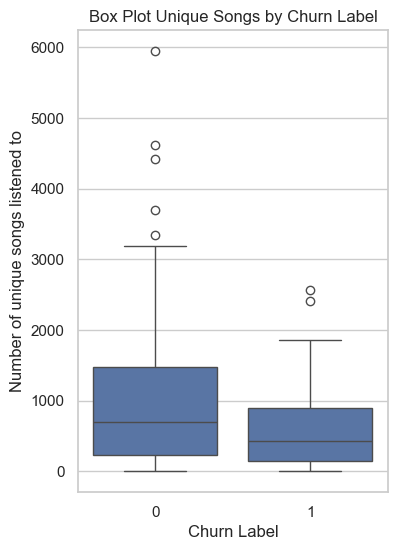

In [105]:
sns.set(style="whitegrid")

plt.figure(figsize=(4, 6))
sns.boxplot(x="churn_lab", y="UniqueSongs", data=unique_song_userid.toPandas())

plt.xlabel('Churn Label')
plt.ylabel('Number of unique songs listened to')
plt.title('Box Plot Unique Songs by Churn Label')

plt.show()

status

In [106]:
spark.sql('SELECT status, COUNT(status) AS count\
           FROM user_log_table_clean\
           GROUP BY status').show()

+------+------+
|status| count|
+------+------+
|   307| 23184|
|   404|   252|
|   200|254718|
+------+------+



dropping this column

- itemInSession

In [107]:
itemsession_per_user = user_log_clean_churn.select('itemInSession','userId','churn_lab').groupBy('userId','churn_lab').agg(spark_sum('itemInSession').alias('total_items'))

In [108]:
itemsession_per_user.show()

+------+---------+-----------+
|userId|churn_lab|total_items|
+------+---------+-----------+
|    19|        0|      35787|
|    50|        0|      38269|
|    30|        0|     153981|
|     8|        0|      16650|
|     4|        0|     371556|
|    65|        0|     257775|
|   101|        1|     558026|
|    13|        0|     122176|
|    42|        0|     346961|
|    94|        0|       4593|
|    62|        0|     374198|
|   114|        0|     122924|
|   144|        0|       4682|
|    78|        0|      10082|
|    59|        0|      86789|
|   105|        1|     119980|
|     3|        1|      11834|
|   127|        0|     262073|
|   132|        0|     318032|
|     7|        0|       5593|
+------+---------+-----------+
only showing top 20 rows



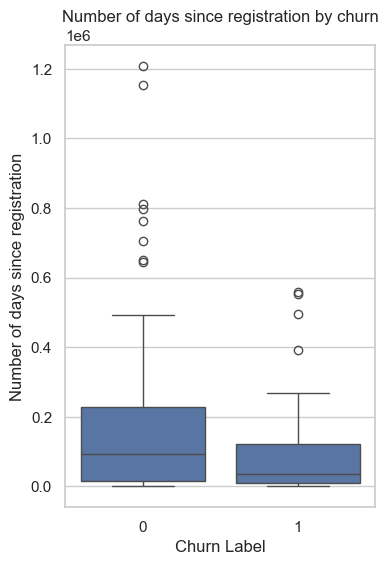

In [109]:
sns.set(style="whitegrid")

plt.figure(figsize=(4, 6))
sns.boxplot(x="churn_lab", y="total_items", data=itemsession_per_user.toPandas())

plt.xlabel('Churn Label')
plt.ylabel('Number of days since registration')
plt.title('Number of days since registration by churn')

plt.show()

userAgent

In [110]:
user_log_clean_churn.take(1)

[Row(artist='Martha Tilston', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0, city='Bakersfield', state='CA', state1='CA')]

In [111]:
userAgent_userid = (
    user_log_clean_churn.groupBy("userId")
    .agg(first("userAgent").alias("userAgent"),
        first("churn_lab").alias("churn_lab")  # Assuming it's a binary label (0 or 1)
    )
)

In [112]:
userAgent_userid.toPandas()['userAgent'].unique()

array(['"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
       'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
       'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0',
       'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0',
       'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
       '"Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
       '"Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
       'Mozilla/5.0 (Macintosh; In

there is a lot of information in this column. It is diffidult to understand why there are so many platforms for each user so I will drop userAgent for now.

- ts_todate

In [113]:
user_log_clean_churn.take(1)

[Row(artist='Martha Tilston', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0, city='Bakersfield', state='CA', state1='CA')]

In [114]:
#isolate userid and dates
columns=['userId', 'ts_todate','registration_todate','churn_lab']
dates_df = user_log_clean_churn.select(columns)


In [115]:
dates_df= dates_df.withColumn("RegistrationDate", col("registration_todate").cast("date"))
dates_df = dates_df.withColumn("SessionDate", col("ts_todate").cast("date"))


In [116]:
dates_df.take(1)

[Row(userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0, RegistrationDate=datetime.date(2018, 9, 28), SessionDate=datetime.date(2018, 9, 30))]

In [117]:
dates_df = dates_df.withColumn("NumDaysSinceRegistration", datediff(col("SessionDate"), col("RegistrationDate")))


In [118]:
dates_df.take(1)

[Row(userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0, RegistrationDate=datetime.date(2018, 9, 28), SessionDate=datetime.date(2018, 9, 30), NumDaysSinceRegistration=2)]

In [119]:
dates_df = dates_df.groupBy("userId").agg(
    first("churn_lab").alias("churn_lab"),
    first("NumDaysSinceRegistration").alias("NumDaysSinceRegistration")
)

In [120]:
dates_df.show()

+------+---------+------------------------+
|userId|churn_lab|NumDaysSinceRegistration|
+------+---------+------------------------+
|    51|        1|                       4|
|   124|        0|                      72|
|     7|        0|                      22|
|    54|        1|                      68|
|    15|        0|                       2|
|   132|        0|                      17|
|   101|        1|                      38|
|    11|        0|                      71|
|   138|        0|                      10|
|    29|        1|                      16|
|    69|        0|                      20|
|    42|        0|                       7|
|   112|        0|                      31|
|    87|        1|                      40|
|    73|        1|                      28|
|     3|        1|                      53|
|    30|        0|                       2|
|   113|        0|                      64|
|    34|        0|                      29|
|    59|        0|              

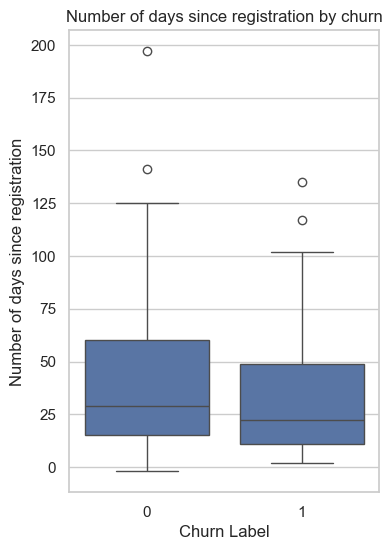

In [121]:
sns.set(style="whitegrid")

plt.figure(figsize=(4, 6))
sns.boxplot(x="churn_lab", y="NumDaysSinceRegistration", data=dates_df.toPandas())

plt.xlabel('Churn Label')
plt.ylabel('Number of days since registration')
plt.title('Number of days since registration by churn')

plt.show()

More features with time
- average number of sessions per day
- average number of sessions per month
- average number of items per day
- average number of items per month

In [122]:
user_log_clean_churn.take(1)

[Row(artist='Martha Tilston', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0, city='Bakersfield', state='CA', state1='CA')]

In [123]:
user_log_clean_churn = user_log_clean_churn.withColumn('month', month('ts_todate'))


In [124]:
user_log_clean_churn.take(1)

[Row(artist='Martha Tilston', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0, city='Bakersfield', state='CA', state1='CA', month=9)]

In [125]:
sessions_month = user_log_clean_churn.groupBy('userId','month','churn_lab').agg(count('*').alias('sessions_month'))

In [126]:
avg_session_month = sessions_month.groupBy('userID','churn_lab').agg(spark_avg('sessions_month').alias('avg_session_month'))

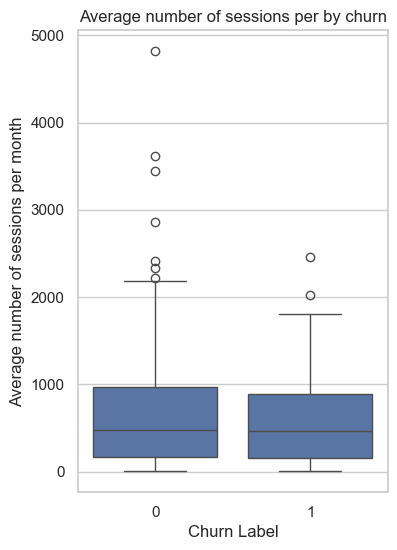

In [127]:
sns.set(style="whitegrid")

plt.figure(figsize=(4, 6))
sns.boxplot(x="churn_lab", y="avg_session_month", data=avg_session_month.toPandas())

plt.xlabel('Churn Label')
plt.ylabel('Average number of sessions per month')
plt.title('Average number of sessions per by churn')

plt.show()

In [128]:
sessions_day = user_log_clean_churn.groupBy('userId','ts_todate','churn_lab').agg(count('*').alias('sessions_day'))

In [129]:
sessions_day.show()

+------+----------+---------+------------+
|userId| ts_todate|churn_lab|sessions_day|
+------+----------+---------+------------+
|   111|2018-10-04|        0|          19|
|    12|2018-10-09|        1|          58|
|   124|2018-10-10|        0|          11|
|    16|2018-10-04|        0|         126|
|   105|2018-10-11|        1|          65|
|    45|2018-10-07|        0|          57|
|   104|2018-10-11|        0|          60|
|    85|2018-10-05|        0|          37|
|    51|2018-10-07|        1|         191|
|   129|2018-10-02|        1|           1|
|    20|2018-10-08|        0|          11|
|    35|2018-10-10|        0|          14|
|    25|2018-10-01|        0|          97|
|    39|2018-10-08|        0|          80|
|    15|2018-10-09|        0|         146|
|   117|2018-10-02|        0|          10|
|   101|2018-10-03|        1|          97|
|    60|2018-10-11|        0|          36|
|    92|2018-10-04|        0|          34|
|   131|2018-10-09|        0|          29|
+------+---

In [130]:
avg_session_day = sessions_day.groupBy('userID','churn_lab').agg(spark_avg('sessions_day').alias('avg_session_day'))

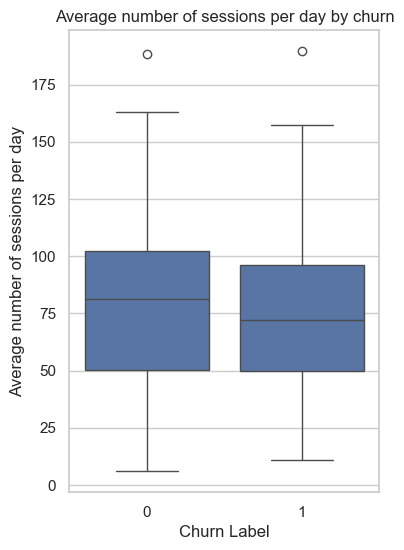

In [131]:
sns.set(style="whitegrid")

plt.figure(figsize=(4, 6))
sns.boxplot(x="churn_lab", y="avg_session_day", data=avg_session_day.toPandas())

plt.xlabel('Churn Label')
plt.ylabel('Average number of sessions per day')
plt.title('Average number of sessions per day by churn')

plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [132]:
#let's take a look at the schema again
user_log_clean_churn.printSchema()  

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- ts_todate: date (nullable = true)
 |-- registration_todate: date (nullable = true)
 |-- churn_lab: integer (nullable = false)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state1: string (nullable = true)
 |-- month: integer (nullable = true)



## Final check and decision for each feature
```
 |-- artist: string (nullable = true) -> 1 col with count of unique artists per user
 |-- gender: string (nullable = true) -> 1 col with gender per user
 |-- itemInSession: long (nullable = true) -> 1 col with
 |-- length: double (nullable = true) -> 2 cols avg and session total length
 |-- level: string (nullable = true)  -> drop
 |-- location: string (nullable = true) -> 1 col first state per user
 |-- page: string (nullable = true) -> 1 col of number of unique pages visited by user + count of each page visited by user (+19)
 |-- sessionId: long (nullable = true) -> drop
 |-- song: string (nullable = true) -> 1 col count of unique songs per user
 |-- status: long (nullable = true) -> drop
 |-- userAgent: string (nullable = true) -> drop
 |-- userId: string (nullable = true) -> 1 col as is
 |-- ts_todate: date (nullable = true) -> 
 |-- registration_todate: date (nullable = true)-> 1 col of number of days after registration
 |-- churn_lab: integer (nullable = false) -> 1 col churn type per user
 |-- city: string (nullable = true) -> drop
 |-- state: string (nullable = true) -> drop
 |-- state1: string (nullable = true) -> keep for 1 col state by user (see location)
 ```

- select features to keep
- define what features need to be engineered and what to do
-- timestamp

#create udf functions using lambda
function_name = udf(lambda x: action(, x), IntegerType())

#to create new columns
df.withColumn("newcolname",function(df.oldcolname))

In [133]:
user_log_clean_churn.take(1)

[Row(artist='Martha Tilston', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 9, 30), registration_todate=datetime.date(2018, 9, 28), churn_lab=0, city='Bakersfield', state='CA', state1='CA', month=9)]

In [134]:
def create_features(df):
    '''This function takes a clean spark dataframe of sparkify records and 
    creates new features for each userId based on different aggregations, then combine all the new feature 
    into a final df called user_df. This user_df is saved into a csv file
  
    Input: df - spark dataframe
    Output: user_df - spark dataframe including one row per userId and new features'''
    
    
    #new features and aggregation by feature
   #allows to aggregate many features in one step
    agg_df1 = df.groupBy('userId').agg(
                             first('gender').alias('gender'), #takes the first occurence of gender for each user
                             countDistinct('artist').alias('unique_artist_count'), #counting the unique artist per userId
                             first('state1').alias('state'), #retrieving state information for each userId
                             spark_sum('length').alias('total_session_length'),
                             spark_avg('length').alias('avg_session_length'),
                             first('churn_lab').alias('churn_label'),
                             countDistinct('song').alias('unique_song_count'),
                             spark_sum('itemInSession').alias('total_items'),
                             spark_avg('itemInSession').alias('avg_items')
       
       
       
   )
   #aggregate by month
    agg_df2 = df.groupBy('userId','month').agg(
                              spark_sum("length").alias("session_length_per_month"),
                              spark_sum('itemInSession').alias('items_per_month'),
                              count('*').alias('count_sessions_per_month')
    )
    
    agg_df2 = agg_df2.groupBy('userId').agg(
                              spark_avg('session_length_per_month').alias('avg_session_length_per_month'),
                              spark_avg('items_per_month').alias('avg_items_per_month'),
                              spark_avg('count_sessions_per_month').alias('avg_count_session_per_month')
    )
    #aggregate by day
    agg_df3 = df.groupBy('userId','ts_todate').agg(
                              spark_sum("length").alias("session_length_per_day"),
                              spark_sum('itemInSession').alias('items_per_day'),
                              count('*').alias('count_sessions_per_day')
    )
    agg_df3 = agg_df3.groupBy('userId').agg(
                              spark_avg('session_length_per_day').alias('avg_session_length_per_day'),
                              spark_avg('items_per_day').alias('avg_items_per_day'),
                              spark_avg('count_sessions_per_day').alias('avg_count_session_per_day')
    )
   
    # aggregate counts per page per user
    page_counts_per_user = df.groupBy('userId', 'page').count()
    agg_df4 = page_counts_per_user.groupBy('userId').pivot('page').sum('count')
    agg_df4 = agg_df4.na.fill(0)
    agg_df4 = agg_df4.select([col(col_name).alias(col_name.replace(" ", "_")) for col_name in agg_df4.columns])




    
    #join all agg_df
    
    user_df = agg_df1.join(agg_df2,['userid']) 
    user_df = user_df.join(agg_df3,['userid'])
    user_df = user_df.join(agg_df4,['userid'])

    return user_df

In [135]:
#function test
test_create_features = create_features(user_log_clean_churn)

In [136]:
test_create_features.toPandas().head()

24/02/29 09:19:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,userId,gender,unique_artist_count,state,total_session_length,avg_session_length,churn_label,unique_song_count,total_items,avg_items,...,Logout,NextSong,Roll_Advert,Save_Settings,Settings,Submit_Downgrade,Submit_Upgrade,Thumbs_Down,Thumbs_Up,Upgrade
0,10,M,565,MS,166866.37251,247.944090,0,629,116260,146.238994,...,11,673,1,1,7,0,0,4,37,0
1,100,M,1705,TX,672877.85659,250.886598,0,2302,287058,89.314872,...,35,2682,25,5,11,1,1,27,148,1
2,100001,F,125,FL,35073.74215,263.712347,1,129,5332,28.513369,...,7,133,14,0,1,0,0,2,8,2
3,100002,F,184,CA,49559.91810,254.153426,0,193,18198,83.477064,...,1,195,3,0,0,0,0,0,5,0
4,100003,F,50,FL,12306.41932,241.302340,1,51,3171,40.653846,...,3,51,9,0,0,0,0,0,3,0


In [137]:
# function that removed missing row with missing userid
#removing rows for all missing userId
def remove_missing_userid(df):
    condition = user_log.userId != ''
    df= df.filter(condition)
    
    return df
    

In [139]:
def create_churn_label(df):
    ''' This function takes a dataframe and creates churn labels based on the 
    churn definition: Cancellation Confirmation value in 'pages' is considered churn.
    
    Input = Spark dataframe
    
    Output = Spark dataframe with new column 'churn_lab' for each user who churned
    '''
    #labeling all 'pages' with Cancellation Confirmation
    create_churn = udf(lambda x: 1 if x =="Cancellation Confirmation" else 0, IntegerType())
    df = df.withColumn('churn_lab_temp', create_churn('page'))
    
    #extract a list of churn users from the new df
    churn_userid = df.select('userId').where(col('churn_lab_temp')==1).groupby('userId').count()
    churn_userid_list = [row['userId'] for row in churn_userid.collect()]
    
    #new column based on the churn list
    df = df.withColumn('churn_lab', when((df.userId).isin(churn_userid_list), 1).otherwise(0))
    
    #dropping column
    df = df.drop('churn_lab_temp')
    
    return df   
    

In [141]:
#function that prepares data from original json file
def prepare_data(df):
    '''This function starts with the json file (including records of activities for sparkify) 
    and goes through the following steps of data preparation:
    - treatment of missing data
    - data format transformation
    - feature engineering
    - saves the final dataframe into a csv file
    
    The output dataset is a dataframe of features for each user identified in the original json record
    
    input: dataframe from json file opened in a spark session called df
    
    output: dataframe user_df
    '''
    
    #treating missing data
    df = remove_missing_userid(df)
    
    #feature drop
    cols = ('firstname','lastname','method','auth','level','sessionId','status','userAgent')
    df = df.drop(*cols)

    #change format dates
    cols = ("ts","registration","ts_ts","registration_ts")
    
    df = df.withColumn('ts_ts', (col('ts') / 1000.0).cast(TimestampType())) \
      .withColumn('ts_todate', to_date('ts_ts')) \
      .withColumn('registration_ts', (col('registration') / 1000.0).cast(TimestampType())) \
      .withColumn('registration_todate', to_date('registration_ts')) \
      .drop(*cols)
    df = df.withColumn('month', month('ts_todate'))

    
    #prepare location data
    split_col_location = pyspark.sql.functions.split(df['location'], ', ')
    df = df.withColumn('state', split_col_location.getItem(1))\
    
    split_col_state = pyspark.sql.functions.split(df['state'], '-')
    df = df.withColumn('state1', split_col_state.getItem(0))

    
    df = create_churn_label(df)
   
    #create new features
    user_df = create_features(df)
    
    return user_df
    

#### Testing my prepare date function by reloading the original dataset

In [143]:
#test data preparation function with original dataset
user_log = spark.read.json("file://" +SparkFiles.get("mini_sparkify_event_data.json"))
user_log.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [144]:
user_data_df = prepare_data(user_log)

In [145]:
user_data_df.take(1)

[Row(userId='10', gender='M', unique_artist_count=565, state='MS', total_session_length=166866.37250999996, avg_session_length=247.94408991084688, churn_label=0, unique_song_count=629, total_items=116260, avg_items=146.23899371069183, avg_session_length_per_month=83433.18625499998, avg_items_per_month=58130.0, avg_count_session_per_month=397.5, avg_session_length_per_day=18540.70805666667, avg_items_per_day=12917.777777777777, avg_count_session_per_day=88.33333333333333, About=2, Add_Friend=12, Add_to_Playlist=9, Cancel=0, Cancellation_Confirmation=0, Downgrade=7, Error=0, Help=1, Home=30, Logout=11, NextSong=673, Roll_Advert=1, Save_Settings=1, Settings=7, Submit_Downgrade=0, Submit_Upgrade=0, Thumbs_Down=4, Thumbs_Up=37, Upgrade=0)]

In [146]:
list(user_data_df.columns)

['userId',
 'gender',
 'unique_artist_count',
 'state',
 'total_session_length',
 'avg_session_length',
 'churn_label',
 'unique_song_count',
 'total_items',
 'avg_items',
 'avg_session_length_per_month',
 'avg_items_per_month',
 'avg_count_session_per_month',
 'avg_session_length_per_day',
 'avg_items_per_day',
 'avg_count_session_per_day',
 'About',
 'Add_Friend',
 'Add_to_Playlist',
 'Cancel',
 'Cancellation_Confirmation',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll_Advert',
 'Save_Settings',
 'Settings',
 'Submit_Downgrade',
 'Submit_Upgrade',
 'Thumbs_Down',
 'Thumbs_Up',
 'Upgrade']

My new dataset for model training is ready. Let's move on to model training

## Modeling
"Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize."

Before splitting the dataset, I will index the two categorical features I kept which are gender and state data.

In [147]:
#indexing categorical values which are letters
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
state_indexer = StringIndexer(inputCol="state", outputCol="state_index")
indexed_data = gender_indexer.fit(user_data_df).transform(user_data_df)
indexed_data = state_indexer.fit(indexed_data).transform(indexed_data)


Now, I am splitting the dataset into 3 sets, the train set (70%) of the whole set, and the validation and test sets are the 30% remaining data, divided by 2.

In [148]:
#splitting data into train and remainder that will be used for validation and test sets
train_df, remaining_df = indexed_data.randomSplit([0.7, 0.3], seed=42)

# The second split: 50% of the remaining data for validation, 50% for testing
validation_df, test_df = remaining_df.randomSplit([0.5, 0.5], seed=42)

Next, I am creating function to transform my data prior to model training. These will be integrated into the pipeline.

In [149]:
def create_encoders():
    gender_encoder = OneHotEncoder(inputCol="gender_index",
                                   outputCol="gender_encoded")
    state_encoder = OneHotEncoder(inputCol="state_index",
                                  outputCol="state_encoded")
    return [gender_encoder, state_encoder]


#feature assembler function will take all the columns listed below to output them as the features to train.
def create_feature_assembler():
    cols_for_assembler = [
        'unique_artist_count', 'total_session_length', 'avg_session_length',
        'unique_song_count', 'total_items', 'avg_items',
        'avg_session_length_per_month', 'avg_items_per_month',
        'avg_count_session_per_month', 'avg_session_length_per_day',
        'avg_items_per_day', 'avg_count_session_per_day', 'About', 'Add_Friend',
        'Add_to_Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout',
        'NextSong', 'Roll_Advert', 'Save_Settings', 'Settings',
        'Submit_Downgrade', 'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up',
        'Upgrade', 'state_encoded', 'gender_encoded'
    ]

    assembler = VectorAssembler(inputCols=cols_for_assembler,
                                outputCol="features")
    return assembler


#scaler function
def create_scaler():
    scaler = StandardScaler(inputCol='features',
                            outputCol='scaled_features',
                            withStd=True,
                            withMean=True)
    return scaler


#label indexer function: creates the label column based on the churn_label column I created from data preparation.
def create_label_indexer():
    label_indexer = StringIndexer(inputCol='churn_label', outputCol='label')
    return label_indexer

Now I am instantiating the different transformation steps based on the functions I wrote above. I am then combining the steps into a pipeline called transform_pipeline. This will allow me to call for the transform pipeline more easily but still separate the model with data transformation.

In [151]:
# creating a pipeline including the preprocessing steps based on the functions above. I combined all the steps into a pipeline called transform_pipeline.
encoders = create_encoders()
assembler = create_feature_assembler()
scaler = create_scaler()
label_indexer = create_label_indexer()
transform_pipeline = Pipeline(
    stages=[*encoders, assembler, scaler, label_indexer])

In [152]:
#fitting transform pipeline
fitted_transform_pipeline = transform_pipeline.fit(train_df)

In [154]:
#preprocessing the train and test sets separately to avoid leak
train_transformed_data = fitted_transform_pipeline.transform(train_df)
validation_transformed_data = fitted_transform_pipeline.transform(validation_df)

In [158]:
#function that trains and evaluate a model, I have put two metrics AUC and F1 as metrics
def train_and_evaluate_model(model, train_data, validation_data):

    trained_model = model.fit(train_data)
    predictions = trained_model.transform(validation_data)

    evaluator = BinaryClassificationEvaluator()
    auc = evaluator.evaluate(predictions)

    evaluator_f1 = MulticlassClassificationEvaluator(metricName="f1")
    f1_score = evaluator_f1.evaluate(predictions)

    return trained_model, auc, f1_score, predictions

In [159]:
#defining my models to train and compare
rf_model = RandomForestClassifier(featuresCol='scaled_features',
                                  labelCol='label')
lr_model = LogisticRegression(featuresCol='scaled_features', labelCol='label')
gbt_model = GBTClassifier(featuresCol='scaled_features', labelCol='label')

In [160]:
#training and evaluating based on the function created above
rf_trained_model, rf_auc, rf_f1, rf_predictions = train_and_evaluate_model(
    rf_model, train_transformed_data, validation_transformed_data)
lr_trained_model, lr_auc, lr_f1, lr_predictions = train_and_evaluate_model(
    lr_model, train_transformed_data, validation_transformed_data)
gbt_trained_model, gbt_auc, gbt_f1, gbt_predictions = train_and_evaluate_model(
    gbt_model, train_transformed_data, validation_transformed_data)

### Compare evaluators across models and select the best one

In [162]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType

def create_metrics_table(models, auc_scores, f1_scores):
    """
    Create a PySpark DataFrame with model names, AUC scores, and F1 scores.

    Input:
    - models (list): List of model names.
    - auc_scores (list): List of AUC scores.
    - f1_scores (list): List of F1 scores.

    Output: Spark DataFrame
    """

    # Define the schema for the DataFrame
    schema = StructType([
        StructField("Model", StringType(), True),
        StructField("AUC", FloatType(), True),
        StructField("F1 Score", FloatType(), True)
    ])

    # Create a list of tuples with model names and corresponding metrics
    data = list(zip(models, auc_scores, f1_scores))

    # Create a DataFrame
    df = spark.createDataFrame(data, schema=schema)

    return df


In [163]:
models = ['Random Forest', 'Logistic Regression', 'Gradient Boosting']
auc_scores = [rf_auc, lr_auc, gbt_auc]
f1_scores = [rf_f1, lr_f1, gbt_f1]

result_df = create_metrics_table(models, auc_scores, f1_scores)
result_df.show()

/Users/isabellevea/anaconda3/envs/streamlit/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py:154: DeprecationWarning: This process (pid=42173) is multi-threaded, use of fork() may lead to deadlocks in the child.


+-------------------+----------+----------+
|              Model|       AUC|  F1 Score|
+-------------------+----------+----------+
|      Random Forest|0.62352943| 0.6507177|
|Logistic Regression| 0.5882353|0.70075756|
|  Gradient Boosting| 0.6117647|0.66868687|
+-------------------+----------+----------+



Even if we calculated the AUC, since our dataset is small, we are using the f1 score and based on f1, the logistic regression model is the best model. 

### Fine tuning selected model

Based on the F1 metric, the best trained model is the logistic regression model. I am now going to take that model and fine tune it using CrossValidator

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [164]:
# Create a pipeline with the Logistic Regression model
pipeline = Pipeline(stages=[*encoders, assembler, scaler, label_indexer, lr_model]) 
#here note that I am inputing all transformation steps separately to be able to retrieve the coefficients

# Create a grid of hyperparameters to search over
param_grid = (ParamGridBuilder()
              .addGrid(lr_model.regParam, [0.01, 0.1, 0.5])
              .addGrid(lr_model.elasticNetParam, [0.0, 0.5, 1.0])
              .addGrid(lr_model.maxIter, [10, 20, 30])
              .build())

# Define an evaluator (you may adjust this based on your specific evaluation metric)
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

# Create a CrossValidator
cross_val = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=5)  # You can adjust the number of folds

# Run cross-validation and choose the best set of parameters
cv_model = cross_val.fit(train_df)

# Saving the best model into best_model from the cross validation
best_model = cv_model.bestModel

print("Best Parameters: regParam={}, elasticNetParam={}, maxIter={}".format(
    best_model.stages[-1].getRegParam(),
    best_model.stages[-1].getElasticNetParam(),
    best_model.stages[-1].getMaxIter()
))


Best Parameters: regParam=0.01, elasticNetParam=0.5, maxIter=10


In [ ]:
val_predictions = best_model.transform(validation_df)

# Area under ROC
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
area_under_roc = evaluator.evaluate(valpredictions)
print("Area Under ROC on Test Set: {:.4f}".format(area_under_roc))

#F1 score
evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

f1_score = evaluator_f1.evaluate(val_predictions)
print(f'F1 score for LR model: {f1_score}')

Area Under ROC on Test Set: 0.5593


F1 score for LR model: 0.6807168458781362


In this case, the F1 score decreases when I used Cross Validator to tune the model. I will use lr_trained_model as the best model

In [165]:
best_model = lr_trained_model

In [166]:
lr_predictions.columns

['userId',
 'gender',
 'unique_artist_count',
 'state',
 'total_session_length',
 'avg_session_length',
 'churn_label',
 'unique_song_count',
 'total_items',
 'avg_items',
 'avg_session_length_per_month',
 'avg_items_per_month',
 'avg_count_session_per_month',
 'avg_session_length_per_day',
 'avg_items_per_day',
 'avg_count_session_per_day',
 'About',
 'Add_Friend',
 'Add_to_Playlist',
 'Cancel',
 'Cancellation_Confirmation',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll_Advert',
 'Save_Settings',
 'Settings',
 'Submit_Downgrade',
 'Submit_Upgrade',
 'Thumbs_Down',
 'Thumbs_Up',
 'Upgrade',
 'gender_index',
 'state_index',
 'gender_encoded',
 'state_encoded',
 'features',
 'scaled_features',
 'label',
 'rawPrediction',
 'probability',
 'prediction']

Based on model selection and tuning, my final model is best_model. 
I am now going to predict churn in my test set, and provide a list of potential churning users as well as a confusiong matrix.

In [168]:
#making predictions on the test set
test_transformed_data = fitted_transform_pipeline.transform(test_df)
test_predictions = best_model.transform(test_transformed_data)


Now let's create a confusion matrix that will show how the model predicted churn on my test set.

In [271]:
from pyspark.sql.functions import expr


# Extract true positive, false positive, true negative, and false negative counts
tp = test_predictions.filter((test_predictions["prediction"] == 1.0) & (test_predictions["label"] == 1.0)).count()
fp = test_predictions.filter((test_predictions["prediction"] == 1.0) & (test_predictions["label"] == 0.0)).count()
tn = test_predictions.filter((test_predictions["prediction"] == 0.0) & (test_predictions["label"] == 0.0)).count()
fn = test_predictions.filter((test_predictions["prediction"] == 0.0) & (test_predictions["label"] == 1.0)).count()

# Display confusion matrix
conf_matrix = [[tn, fp], [fn, tp]]
print("Confusion Matrix:")
print(f"True Positive: {tp}")
print(f"False Positive: {fp}")
print(f"True Negative: {tn}")
print(f"False Negative: {fn}")


Confusion Matrix:
True Positive: 3
False Positive: 1
True Negative: 26
False Negative: 10


Finally, let's show a list of potential churners and the churn likelihood, as well as the true label.


In [169]:
selected_columns = ["userId", "prediction", "probability", "label"]

selected_predictions = test_predictions.select(*selected_columns)

churn_predictions = selected_predictions.filter(selected_predictions["prediction"] == 1.0)

churn_predictions.show()

+------+----------+--------------------+-----+
|userId|prediction|         probability|label|
+------+----------+--------------------+-----+
|100001|       1.0|[0.40989860473846...|  1.0|
|    12|       1.0|[0.01906160390528...|  1.0|
|   154|       1.0|[0.01222102398113...|  0.0|
|    32|       1.0|[0.06707531968020...|  1.0|
+------+----------+--------------------+-----+



In this case, users 100001, 12 and 32 were predicted to churn correctly. User 154 was predicted to churn to didn't

In [176]:
selected_columns = ["userId", "prediction", "probability", "label"]

selected_predictions = test_predictions.select(*selected_columns)

churn_labels = selected_predictions.filter(selected_predictions["label"] == 1.0)

churn_labels.show()

+------+----------+--------------------+-----+
|userId|prediction|         probability|label|
+------+----------+--------------------+-----+
|100001|       1.0|[0.40989860473846...|  1.0|
|100005|       0.0|[0.99364280440059...|  1.0|
|100007|       0.0|[0.99398947263878...|  1.0|
|100012|       0.0|[0.99999995628383...|  1.0|
|100013|       0.0|[0.99999999841705...|  1.0|
|100014|       0.0|[0.58657243031963...|  1.0|
|100021|       0.0|[0.99970612835770...|  1.0|
|100023|       0.0|[0.99999984914402...|  1.0|
|   103|       0.0|[0.99809808119368...|  1.0|
|   105|       0.0|[0.99999999955617...|  1.0|
|    12|       1.0|[0.01906160390528...|  1.0|
|   122|       0.0|[0.99961443546952...|  1.0|
|    32|       1.0|[0.06707531968020...|  1.0|
+------+----------+--------------------+-----+



#### Identifying important features in the model
My final task here is to identify which features controbuted the most to model training. The aim is to create an app with these features as inputs cells so people can use my model to predict the likelihood of churning based on these given features.

In [178]:

coefficients = best_model.coefficients


In [179]:
coefficients

DenseVector([7.6649, -2.8597, 0.6364, -1.1444, 11.753, -2.8122, 2.3779, -3.3777, 13.0836, -18.5314, -4.4419, 19.2354, -3.2322, -7.0231, -3.3599, -2.456, -5.1422, -2.2491, 9.0163, -10.384, -0.4639, 0.0619, -1.2405, -1.6301, -0.4035, 0.2943, 3.3605, -4.8328, -0.059, 0.939, 1.1535, 0.4603, -0.2621, 0.7724, -1.7945, 0.6604, 1.0898, 0.6362, -2.1749, -1.8153, -1.366, 1.2851, -1.103, 0.4365, 3.2713, 0.8766, 0.5584, -0.0121, 0.7399, -1.1195, 0.078, -1.9069, 1.5967, -0.8162, 0.0379, -1.6269, -0.5019, -0.6122, -0.6429, 0.0, -1.31, -0.5809, 0.0, -0.7379, 0.0, 0.0, 0.0, 0.0, -0.3642, -0.871])

In [182]:
coefficients = lr_trained_model.coefficients

# Creating a list of feature names
feature_names = train_transformed_data.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]

# Creating a DataFrame with feature names and coefficients
coefficients_df = pd.DataFrame(list(zip(feature_names, coefficients)), columns=["Feature", "Coefficient"])

# Adding a new column with the absolute values of coefficients
coefficients_df["AbsoluteCoefficient"] = coefficients_df["Coefficient"].abs()

# Sorting the DataFrame based on the absolute coefficients in descending order
sorted_coefficients_df = coefficients_df.sort_values(by="AbsoluteCoefficient", ascending=False)

# Selecting the top features
top_features = sorted_coefficients_df.head(10)["Feature"].tolist()

print("Feature Coefficients:")
print(sorted_coefficients_df[["Feature", "Coefficient"]])

print("Top Features:")
print(top_features)

Feature Coefficients:
                                              Feature  Coefficient
11   {'idx': 11, 'name': 'avg_count_session_per_day'}    19.235405
9    {'idx': 9, 'name': 'avg_session_length_per_day'}   -18.531412
8   {'idx': 8, 'name': 'avg_count_session_per_month'}    13.083578
4                   {'idx': 4, 'name': 'total_items'}    11.752967
19                      {'idx': 19, 'name': 'Logout'}   -10.383973
18                        {'idx': 18, 'name': 'Home'}     9.016285
0           {'idx': 0, 'name': 'unique_artist_count'}     7.664906
13                  {'idx': 13, 'name': 'Add_Friend'}    -7.023058
16                       {'idx': 16, 'name': 'Error'}    -5.142185
27                   {'idx': 27, 'name': 'Thumbs_Up'}    -4.832769
10           {'idx': 10, 'name': 'avg_items_per_day'}    -4.441865
7           {'idx': 7, 'name': 'avg_items_per_month'}    -3.377726
26                 {'idx': 26, 'name': 'Thumbs_Down'}     3.360503
14             {'idx': 14, 'name': 'Add_

testing if the top 10 features does not affect the model performance for the app

In [187]:
feature_names = [feature['name'] for feature in top_features]





In [188]:
feature_names

['avg_count_session_per_day',
 'avg_session_length_per_day',
 'avg_count_session_per_month',
 'total_items',
 'Logout',
 'Home',
 'unique_artist_count',
 'Add_Friend',
 'Error',
 'Thumbs_Up']

I will now retrain the model using the top 10 features and check for the model's performancce

In [246]:

assembler2 = VectorAssembler(inputCols=feature_names,
                                outputCol="features")

In [248]:
transform_pipeline2 = Pipeline(
    stages=[*encoders, assembler2, scaler, label_indexer])
fitted_transform_pipeline2 = transform_pipeline2.fit(train_df)

In [251]:
train_transformed2_data = fitted_transform_pipeline2.transform(train_df)
validation_transformed2_data = fitted_transform_pipeline2.transform(validation_df)

In [252]:
lr_trained_model2, lr_auc2, lr_f12, lr_predictions2 = train_and_evaluate_model(
    lr_model, train_transformed2_data, validation_transformed2_data)


In [258]:
models = [ 'Logistic Regression all data','Logistic Regression top features']
auc_scores = [lr_auc, lr_auc2]
f1_scores = [lr_f1, lr_f12]

result_df = create_metrics_table(models, auc_scores, f1_scores)
result_df.show()

+--------------------+----------+----------+
|               Model|       AUC|  F1 Score|
+--------------------+----------+----------+
|Logistic Regressi...| 0.5882353|0.70075756|
|Logistic Regressi...|0.65882355| 0.8399438|
+--------------------+----------+----------+



It looks like training the model using the top ten features selected from a first training can improve performance. Let's see what happens with the test set.

In [262]:
test_transformed2_data = fitted_transform_pipeline2.transform(test_df)

# Use the trained Logistic Regression model to make predictions
test_predictions2 = lr_trained_model2.transform(test_transformed2_data)

# Display the predictions or use them for further analysis
test_predictions2.show()



+------+------+-------------------+-----+--------------------+------------------+-----------+-----------------+-----------+------------------+----------------------------+-------------------+---------------------------+--------------------------+------------------+-------------------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+------------+-----------+--------------+---------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|userId|gender|unique_artist_count|state|total_session_length|avg_session_length|churn_label|unique_song_count|total_items|         avg_items|avg_session_length_per_month|avg_items_per_month|avg_count_session_per_month|avg_session_length_per_day| avg_items_per_day|avg_count_session_per_day|About|Add_Friend|Add_to_Playlist|Cancel|Cancellation_Co

In [263]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="churn_label", predictionCol="prediction", metricName="f1")

f1_score = evaluator.evaluate(test_predictions2)
print("F1 Score: {:.4f}".format(f1_score))


F1 Score: 0.6474


In [264]:
selected_columns = ["userId", "prediction", "probability", "label"]

selected_predictions2 = test_predictions2.select(*selected_columns)

churn_predictions2 = selected_predictions2.filter(selected_predictions2["prediction"] == 1.0)

churn_predictions2.show()

+------+----------+--------------------+-----+
|userId|prediction|         probability|label|
+------+----------+--------------------+-----+
|100005|       1.0|[0.41946663713481...|  1.0|
|    12|       1.0|[0.28442499105727...|  1.0|
+------+----------+--------------------+-----+



In this model, only 2 users were predicted to churn from the test set. Let's look at the confusion matrix.

In [270]:
# Extract true positive, false positive, true negative, and false negative counts
tp2 = test_predictions2.filter((test_predictions2["prediction"] == 1.0) & (test_predictions2["label"] == 1.0)).count()
fp2 = test_predictions2.filter((test_predictions2["prediction"] == 1.0) & (test_predictions2["label"] == 0.0)).count()
tn2 = test_predictions2.filter((test_predictions2["prediction"] == 0.0) & (test_predictions2["label"] == 0.0)).count()
fn2 = test_predictions2.filter((test_predictions2["prediction"] == 0.0) & (test_predictions2["label"] == 1.0)).count()

# Display confusion matrix
conf_matrix = [[tn2, fp2], [fn2, tp2]]
print("Confusion Matrix:")
print(f"True Positive: {tp2}")
print(f"False Positive: {fp2}")
print(f"True Negative: {tn2}")
print(f"False Negative: {fn2}")

total = test_predictions2.count()


tp_percentage2 = tp2 / total * 100
fp_percentage2 = fp2 / total * 100
tn_percentage2 = tn2 / total * 100
fn_percentage2 = fn2 / total * 100

conf_matrix = [[tn_percentage2, fp_percentage2], [fn_percentage2, tp_percentage2]]
print("Confusion Matrix (Percentages):")
print(f"True Positive: {tp_percentage2:.2f}%")
print(f"False Positive: {fp_percentage2:.2f}%")
print(f"True Negative: {tn_percentage2:.2f}%")
print(f"False Negative: {fn_percentage2:.2f}%")


Confusion Matrix:
True Positive: 2
False Positive: 0
True Negative: 27
False Negative: 11


Confusion Matrix (Percentages):
True Positive: 5.00%
False Positive: 0.00%
True Negative: 67.50%
False Negative: 27.50%


In [274]:

models = ['Logistic Regression all data', 'Logistic Regression top features']
TP = [tp, tp2]
FP = [fp, fp2]
TN = [tn, tn2]
FN = [fn, fn2]

data = {'Model': models, 'True Positive': TP, 'False Positive': FP, 'True Negative': TN, 'False Negative': FN}
confusion_df = pd.DataFrame(data)

confusion_df

,Model,True Positive,False Positive,True Negative,False Negative
0,Logistic Regression all data,3,1,26,10
1,Logistic Regression top features,2,0,27,11
